In [1]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample, keep it lesser than 300 since our log files are only 1 hour long.
# For now(most data are SOL), we can say ANN's prediction is better as seg_length increases
seg_length = 120

# List of parsed logfiles
keyboard = []
keyboard.append(parse_keyboard_log("./logs/JON/SPY/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/MAR/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/HEN/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/ZIR/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/MIT/SOL/keyboard_actions.log"))

mouse = []
mouse.append(parse_mouse_log("./logs/JON/SPY/mouse_actions.log"))
mouse.append(parse_mouse_log("./logs/MAR/SOL/mouse_actions.log"))
mouse.append(parse_mouse_log("./logs/HEN/SOL/mouse_actions.log"))
mouse.append(parse_mouse_log("./logs/ZIR/SOL/mouse_actions.log"))
mouse.append(parse_mouse_log("./logs/MIT/SOL/mouse_actions.log"))


# Empty lists for inserting data
X_actual = []
Y_actual = []

for k in range(len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k],mouse[k], i, seg_length)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())

print(f"Data samples: {len(Y_actual)}")


Data samples: 151


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( 
    f"Train score: {rfc.score(X_train, Y_train)} " +
    f"Test score: {rfc.score(X_test, Y_test)}"
)

# Predict on test set
Y_predict = rfc.predict(X_test)

scores = cross_val_score(rfc, X_actual, Y_actual, cv=5)
scores

Train score: 1.0 Test score: 1.0


array([0.93548387, 0.96666667, 0.96666667, 1.        , 0.93333333])

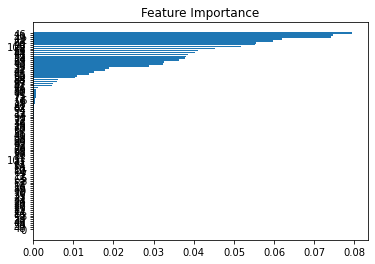

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
indices = np.argsort(importances)

# names = [magicFunctionThatGivesNames() for i in indices]

# Barplot
plt.barh(range(len(indices)), importances[indices])
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(indices)), [indices[i] for i in indices])
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(442.037037037037, 576.5454545454545, 'X[77] <= 0.045\ngini = 0.798\nsamples = 68\nvalue = [23, 20, 20, 26, 24]'),
 Text(419.0740740740741, 521.6363636363636, 'X[8] <= 0.325\ngini = 0.787\nsamples = 63\nvalue = [23, 11, 20, 26, 24]'),
 Text(310.0, 466.72727272727275, 'X[13] <= 0.017\ngini = 0.722\nsamples = 39\nvalue = [23, 11, 1, 9, 21]'),
 Text(229.62962962962962, 411.8181818181818, 'X[2] <= 0.196\ngini = 0.643\nsamples = 32\nvalue = [21, 0, 1, 9, 21]'),
 Text(137.77777777777777, 356.90909090909093, 'X[89] <= 0.715\ngini = 0.568\nsamples = 24\nvalue = [19, 0, 1, 2, 19]'),
 Text(68.88888888888889, 302.0, 'X[69] <= 0.054\ngini = 0.172\nsamples = 14\nvalue = [0, 0, 0, 2, 19]'),
 Text(45.925925925925924, 247.09090909090912, 'X[12] <= 0.071\ngini = 0.095\nsamples = 13\nvalue = [0, 0, 0, 1, 19]'),
 Text(22.962962962962962, 192.1818181818182, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 0, 0, 9]'),
 Text(68.88888888888889, 192.1818181818182, 'X[11] <= 0.943\ngini = 0.165\nsamples = 8\nvalu

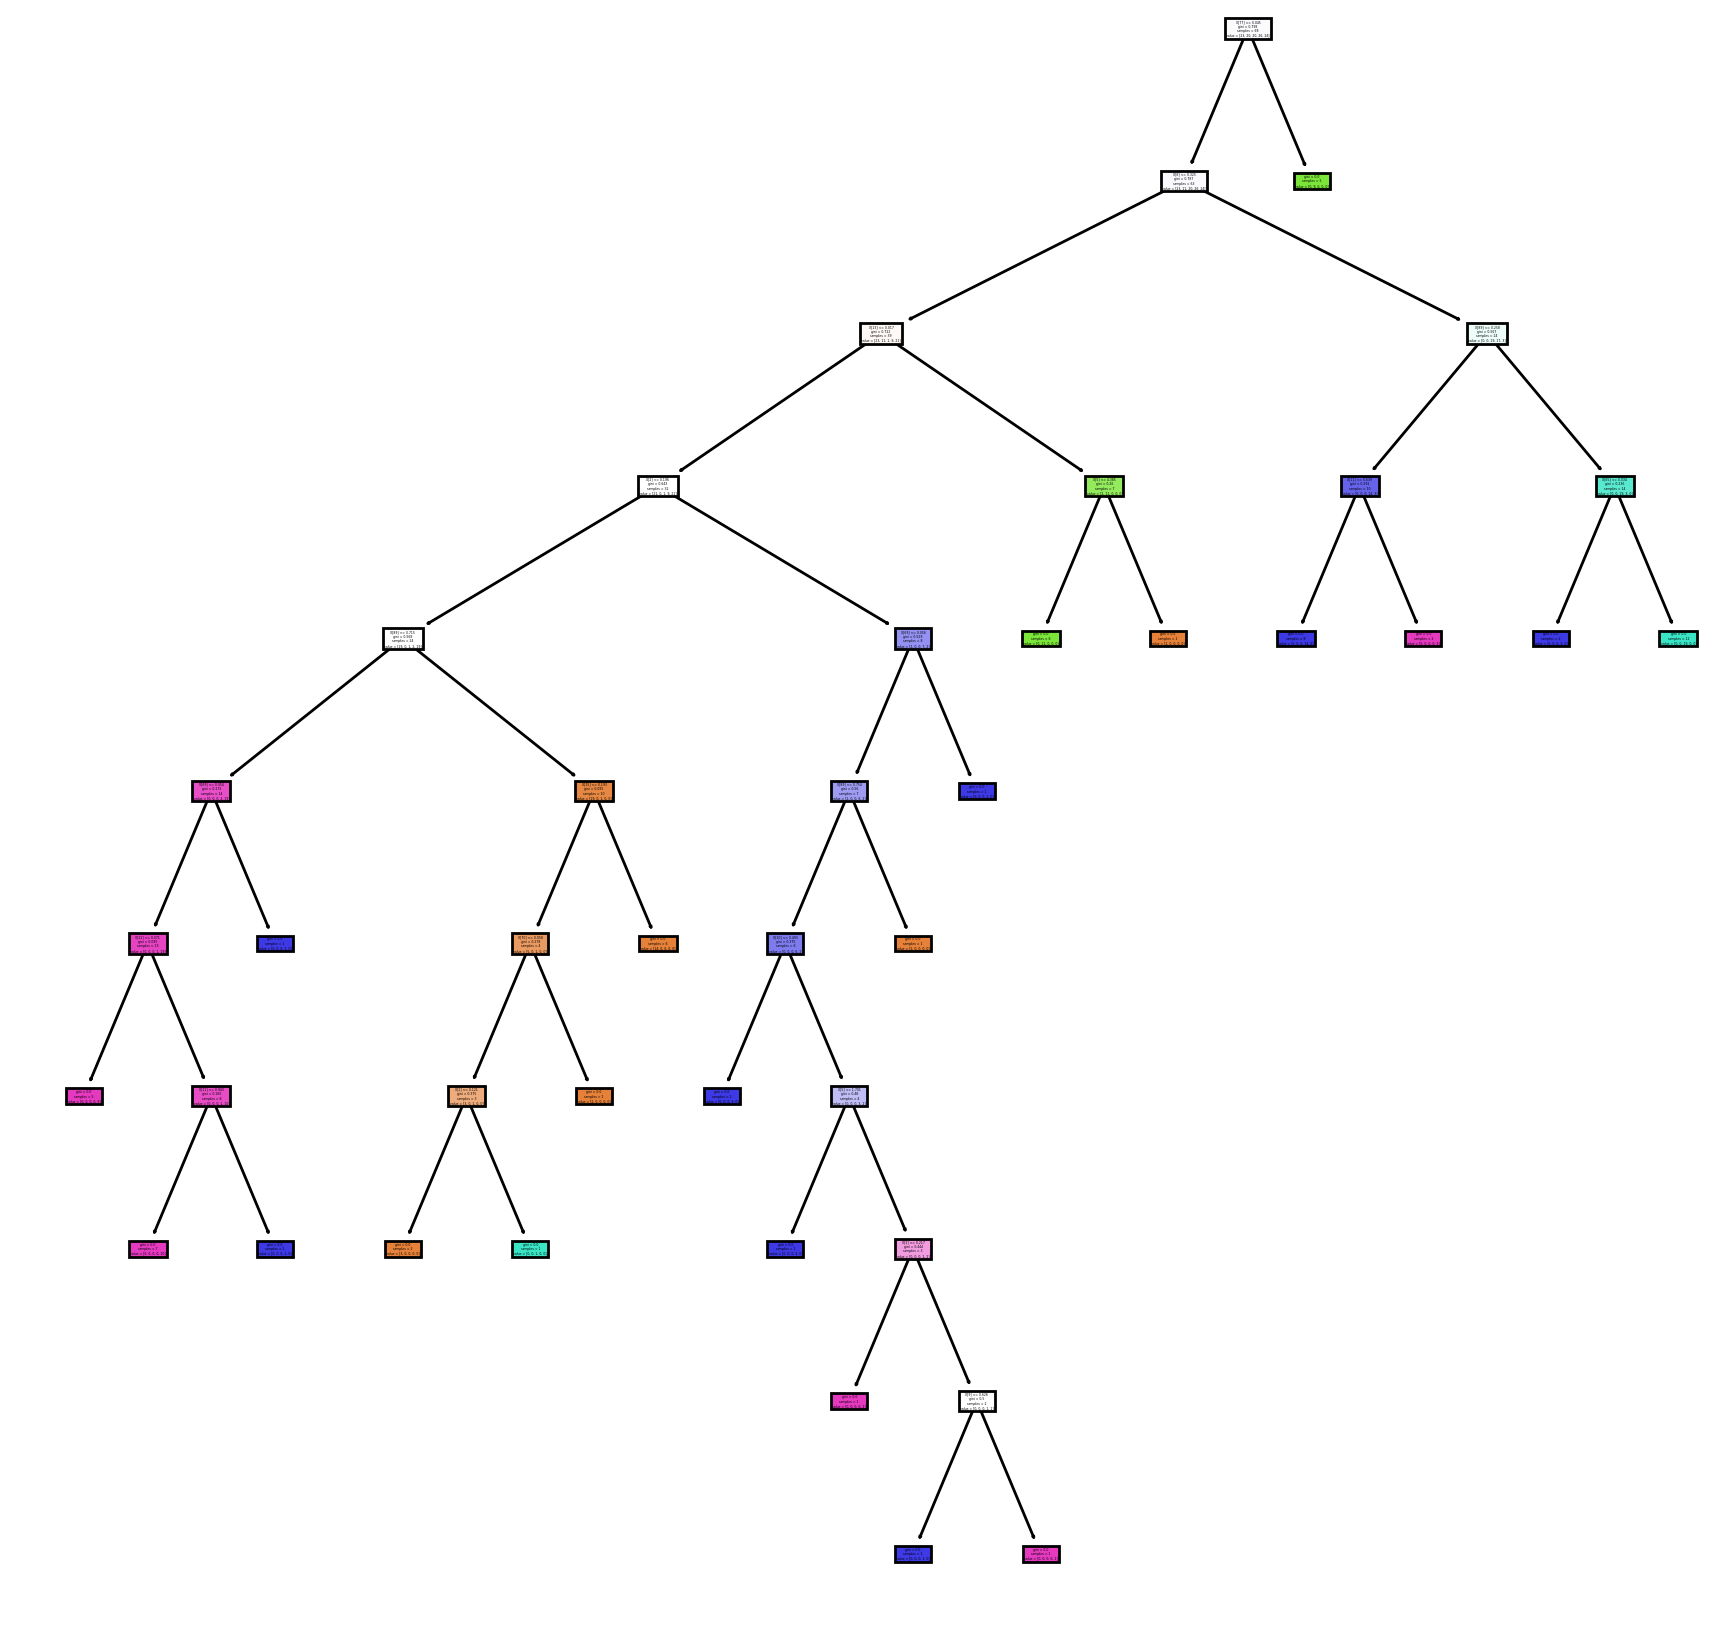

In [5]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], filled = True)